In [636]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [637]:
from config import *
from functions import *
from sim import *
from read_ramses import *
from scipy.interpolate import interp1d
from scipy.special import erfinv, gamma, comb, factorial
from scipy.stats import hypergeom, binom
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from colossus.cosmology import cosmology
from colossus.lss import peaks
cosmo = cosmology.setCosmology('planck18');
import const


### diffuse SNe model

In [993]:
eps_ff = 0.2
n_H = 1e3

rho = const.m_p * n_H
tau_ff = np.sqrt(3*np.pi / (32 * const.G * rho))
rho_sfr = eps_ff * rho / tau_ff


In [994]:
M_cl = 0.2 * 4400 * const.M_sol
Mbig = 10 * const.M_sol
dx = 10 * const.pc

R_s = dx * (Mbig / M_cl)**(1/3)

print(R_s / const.pc)


2.248221565113046


In [992]:
eta = 0.2
tau_cool = 10 * const.Myr
V_sph = 4/3 * np.pi * R_s**3

(1 + Mbig / (eta * rho_sfr * V_sph * tau_cool))**(-1)


0.9665431314019126

### column density PDF

array([0.10692308, 0.27230769])

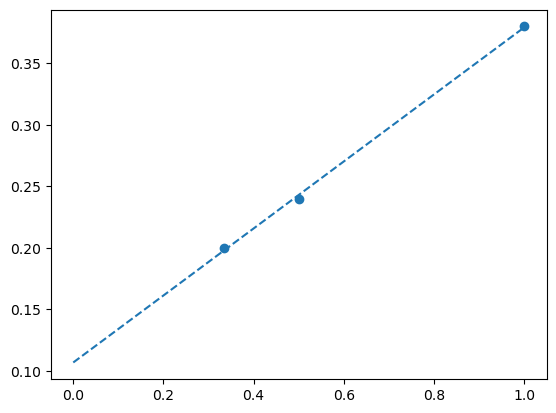

In [2]:
b = np.array([1/3, 0.5, 1.0])
A = np.array([0.2, 0.24, 0.38])

popt, _ = curve_fit(affine, b, A)
x = np.linspace(0, 1)

plt.plot(b, A, 'o')
plt.plot(x, affine(x, *popt), color='C0', linestyle='--')

popt


### overlapping SNe

In [3]:
inhomo = False

nH_form_fid = 10**3
nH_die_fid = 10**0
frac_fid = 0.1
Z_fid = 10*const.Z_sol
Mbig = 10*const.M_sol
eta = 0.2

if inhomo:
    Rcool_fid = 6.3*const.pc
    tcool_fid = 3500*const.yr
    exp1 = -3*(-0.420) + -1*(-0.53)
    exp2 = -3*(-0.050) + -1*(-0.17)
else:
    Rcool_fid = 3*const.pc
    tcool_fid = 2400*const.yr
    exp1 = -3*(-0.420) + -1*(-0.54)
    exp2 = -3*(-0.082) + -1*(-0.20)

3/(4*np.pi) * 1/(Rcool_fid**3*tcool_fid) * np.sqrt(3*np.pi*const.X_cosmo**3/(32*const.G*const.m_p**3)) * Mbig / (frac_fid*eta) * nH_form_fid**(-3/2) * (nH_die_fid/100)**exp1 * (Z_fid/const.Z_sol)**exp2


0.05642307587351495

### IMF calculations

18.729305182374095 0.1895457113453631


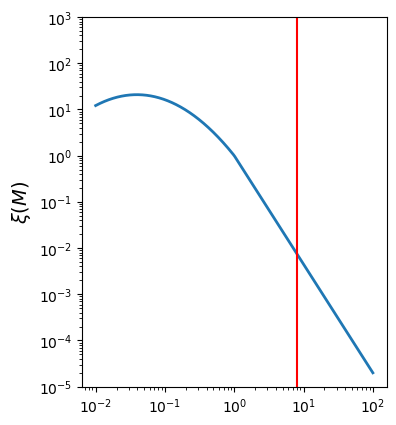

In [171]:
def chabrier(M):
    lognorm = 0.158/(M*np.log(10))*np.exp(-((np.log10(M)-np.log10(0.08))**2)/(2*0.69**2))
    lognorm /= 0.158/np.log(10)*np.exp(-np.log10(0.08)**2/(2*0.69**2))
    powerlaw = M**(-2.35)
    if M <= 1:
        return lognorm
    else:
        return powerlaw
    
def chabrier2(M):
    lognorm = 0.086/(M*np.log(10))*np.exp(-((np.log10(M)-np.log10(0.22))**2)/(2*0.57**2))
    lognorm /= 0.086/np.log(10)*np.exp(-np.log10(0.22)**2/(2*0.57**2))
    powerlaw = M**(-2.35)
    if M <= 1:
        return lognorm
    else:
        return powerlaw

def chabrier_vec(M, system=False):
    IMF = np.zeros_like(M)
    if system:
        lognorm = 0.086/(M*np.log(10))*np.exp(-((np.log10(M)-np.log10(0.22))**2)/(2*0.57**2))
        lognorm /= 0.086/np.log(10)*np.exp(-np.log10(0.22)**2/(2*0.57**2))
    else:
        lognorm = 0.158/(M*np.log(10))*np.exp(-((np.log10(M)-np.log10(0.08))**2)/(2*0.69**2))
        lognorm /= 0.158/np.log(10)*np.exp(-np.log10(0.08)**2/(2*0.69**2))
    powerlaw = M**(-2.35)
    IMF[M<=1] = lognorm[M<=1]
    IMF[M>1] = powerlaw[M>1]
    return IMF

M = np.logspace(-2, 2, 4096*16)

plt.loglog(M, chabrier_vec(M, system=True), lw=2)
plt.ylim(1e-5, 1e3)
plt.ylabel(r'$\xi(M)$', fontsize=14)
plt.gca().set_aspect(2/3)

Mcut = 8
plt.axvline(x=Mcut, color='red')
system = False
Mbig = np.trapz((M*chabrier_vec(M, system=system))[M>Mcut], M[M>Mcut])/np.trapz(chabrier_vec(M, system=system)[M>Mcut], M[M>Mcut])
eta = np.trapz((M*chabrier_vec(M, system=system))[M>Mcut], M[M>Mcut])/np.trapz(M*chabrier_vec(M, system=system), M)

print(Mbig, eta)


In [5]:
Mcut = 15.6
cond = M>Mcut
system=False

Qsol = np.zeros(3)
imf_norm = np.trapz(M*chabrier_vec(M, system=system), M)
for idx_lc in [MS, GI, SG]:
    imf_Q = popt_list[idx_lc][0]*np.trapz((M**popt_list[idx_lc][1]*chabrier_vec(M, system=system))[cond], M[cond]) + popt_list[idx_lc][2]*np.trapz(chabrier_vec(M, system=system)[cond], M[cond])
    Qsol[idx_lc] = 1e49 * imf_Q / imf_norm

print('Qsol (V): %.3g 1/cm^2/s' % (Qsol[MS]))
print('Qsol (III): %.3g 1/cm^2/s' % (Qsol[GI]))
print('Qsol (I): %.3g 1/cm^2/s' % (Qsol[SG]))


NameError: name 'M' is not defined

In [6]:
popt_list


NameError: name 'popt_list' is not defined

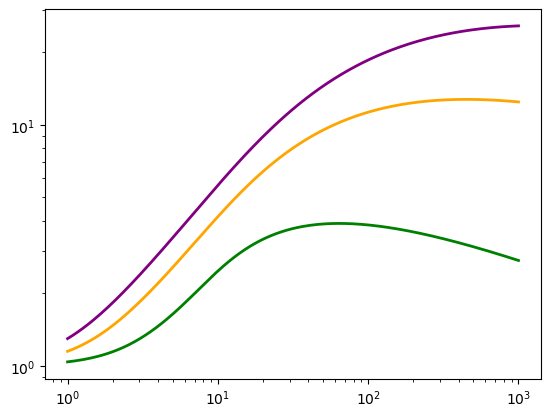

In [78]:
def calc_eps_sf2(density, mach_turb, temp, dx, b_turb=1.0, eps_sf_loc=1.0):
    c_s = np.sqrt(const.k_B * temp / const.m_p) # sound speed
    mach_turb = np.sqrt(2/3 * energy_turb) / c_s # turbulent Mach number
    alpha_vir = 15 / np.pi * c_s**2 * (1 + mach_turb**2) / (const.G * density * dx**2) # virial parameter
    return calc_eps_sf(alpha_vir, mach_turb, b_turb=b_turb, eps_sf_loc=eps_sf_loc)


mach_turb = np.logspace(0, 3, 256)
temp = 10
nH = 1.5
c_s = np.sqrt(const.k_B * temp / const.m_H)
energy_turb = 3/2 * (mach_turb * c_s)**2
density = const.m_H*nH0/const.X_cosmo
dx = 333*const.pc

eps_sf1 = calc_eps_sf2(density, energy_turb, temp, dx, b_turb=0.33)
eps_sf2 = calc_eps_sf2(density, energy_turb, temp, dx, b_turb=0.67)
eps_sf3 = calc_eps_sf2(density, energy_turb, temp, dx, b_turb=1.00)

plt.plot(mach_turb, eps_sf1, lw=2, color='green')
plt.plot(mach_turb, eps_sf2, lw=2, color='orange')
plt.plot(mach_turb, eps_sf3, lw=2, color='purple')
plt.xscale('log')
plt.yscale('log')


### observational comparison

In [3]:
def calc_Mhalo(z, Sigma):
    '''
    Halo mass for a given redshift and surface density.
    
    Args
    Sigma: surface density
    '''
    gal_to_halo=0.1
    Sigma_com = Sigma/(1+z)**2*const.M_sol/const.pc**2
    rho_m = cosmo.rho_m(z)*(const.M_sol*cosmo.h**2/const.kpc**3)
    R_gal = gal_to_halo*(3/(4*np.pi)/rho_m)**(1/3)
    dm_to_b = (cosmo.Om0-cosmo.Ob0)/cosmo.Ob0
    Mhalo = (Sigma_com*np.pi*R_gal**2*dm_to_b)**3
    return Mhalo

def halo_to_star(Mhalo):
    '''
    Halo mass as a function of stellar mass and redshift.
    From Stefanon+2021 (https://arxiv.org/pdf/2103.16571.pdf).
    '''
    beta, gamma, Mc, N = 1.35, 0.4, 10**(11.5)*const.M_sol, 0.0297
    Mstar = Mhalo*2*N*((Mhalo/Mc)**(-beta)+(Mhalo/Mc)**gamma)**(-1.)
    return Mstar


In [4]:
Mhalo = np.logspace(9, 15, 1024)*const.M_sol
Mstar = halo_to_star(Mhalo)
logMstar_to_logMhalo = interp1d(np.log10(Mstar/const.M_sol), np.log10(Mhalo/const.M_sol), fill_value='extrapolate')


In [5]:
# Melia+2023 (https://arxiv.org/pdf/2302.10103.pdf)

JWST_names = [
    "S5-z17-1",
    "CEERS-93316",
    "S5-z12-1",
    "WHL0137-5021",
    "WHL0137-5124",
    "GLASS-z13",
    "GLASS-z12-1",
    "Maisie’s Galaxy",
    "GN-z11",
    "GLASS-z11",
    "WHL0137-3407",
    "WHL0137-5347",
    "WHL0137-5330"
]

JWST_z = np.array([16.66, 16.4, 13.72, 12.8, 12.8, 12.4, 12.22, 11.8, 11.09, 10.6, 10.5, 10.2, 10.0])
JWST_z_p = np.array([1.86, 0.1, 0.86, 1.1, 1.9, 0, 0.04, 0.2, 0.08, 0, 1.0, 0.9, 1.1])
JWST_z_m = np.array([0.34, 0.1, 1.92, 12.5, 12.4, 0, 0.11, 0.3, 0.12, 0, 10.5, 9.7, 7.9])

JWST_logMstar = np.array([8.8, 9.0, 8.1, 8.53, 8.65, 9.0, 8.6, 8.5, 9.0, 9.4, 8.78, 9.01, 8.77])
JWST_logMstar_p = np.array([0.8, 0.4, 1.3, 0.18, 0.20, 0.3, 0.8, 0.29, 0, 0, 0.17, 0.21, 0.15])
JWST_logMstar_m = np.array([0.5, 0.5, 0.3, 0.32, 0.30, 0.4, 0.4, 0.44, 0, 0, 0.33, 0.37, 0.26])

JWST_logMhalo = logMstar_to_logMhalo(JWST_logMstar)
JWST_Mhalo = 10**JWST_logMhalo
JWST_Mhalo_p = 10**logMstar_to_logMhalo(JWST_logMstar+JWST_logMstar_p)-JWST_Mhalo
JWST_Mhalo_m = -10**logMstar_to_logMhalo(JWST_logMstar-JWST_logMstar_m)+JWST_Mhalo


Saved figure as 'peakheight-040220241031.png'


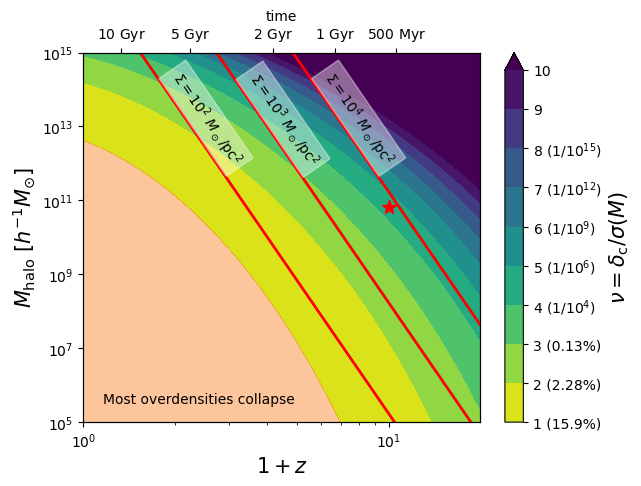

In [213]:
zp1 = np.logspace(0, 1.3, 300)
M = np.logspace(5, 15, 200)
z_grid, M_grid = np.meshgrid(zp1-1, M)
nu = peaks.peakHeight(M_grid, z_grid)

im = plt.contourf(zp1, M, nu, levels=np.arange(1, 11, 1), cmap='viridis_r', extend='max')
plt.contourf(zp1, M, nu, levels=np.arange(0, 2, 1), cmap='Oranges', alpha=0.5)
plt.annotate("Most overdensities collapse", xy=(0.05, 0.05), xycoords='axes fraction', fontsize=10)

for Sigma in [1e2, 1e3, 1e4]:
    Mhalo = calc_Mhalo(zp1-1, Sigma)/const.M_sol
    plt.plot(zp1, Mhalo, lw=2, color='red')
    idx = np.argmin(np.abs(Mhalo-1e12))
    plt.annotate(r'$\Sigma = 10^{%d}~M_\odot/{\rm pc^2}$' % np.log10(Sigma), xy=(zp1[idx]/1.45, Mhalo[idx]), rotation=-55.5, fontsize=10, backgroundcolor=(1, 1, 1, 0.4))

#cond = (JWST_z_p + JWST_z_m) < 4
#plt.errorbar(JWST_z[cond]+1, JWST_Mhalo[cond]*cosmo.h, marker='.', linestyle='', color='red', yerr=(JWST_Mhalo_m[cond], JWST_Mhalo_p[cond]), xerr=(JWST_z_m[cond], JWST_z_p[cond]))
#plt.plot(JWST_z+1, JWST_Mhalo*cosmo.h, marker='.', linestyle='', color='red')
plt.plot(9+1, 1e11*cosmo.h, marker='*', color='red', ms=10)

sigma_frac = (1-erf(np.arange(1, 11)/np.sqrt(2)))/2
tick_labels = ["1 (15.9%)", "2 (2.28%)", "3 (0.13%)", r"4 (1/$10^4$)", r"5 (1/$10^6$)", r"6 (1/$10^9$)", r"7 (1/$10^{12}$)", r"8 (1/$10^{15}$)", "9", "10"]

cbar = plt.colorbar(im, ticks=np.arange(1, 11))
cbar.ax.set_yticklabels(tick_labels)
cbar.set_label(label=r'$\nu = \delta_{\rm c} / \sigma(M)$', size=15)

plt.xscale('log')
plt.yscale('log')

plt.xlim(10**0, 10**1.3)
plt.ylim(1e5, 1e15)

plt.xlabel(r'$1 + z$', fontsize=15)
plt.ylabel(r'$M_{\rm halo}$ [$h^{-1} M_{\odot}$]', fontsize=15)

ax2 = plt.gca().twiny()
ax2.set_xscale('log')
ax2.set_xlabel('time')

aexp_list = np.linspace(1e-3, 1., 2**10)
time_list = np.array([aexp_to_proper_time(aexp_list[i], Omega_m0=cosmo.Om0, Omega_k0=cosmo.Ok0, Omega_L0=cosmo.Ode0, H0=cosmo.H0*const.km/const.Mpc) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list, fill_value='extrapolate')

time_ticks = np.array([500, 1000, 2000, 5000, 10000])*const.Myr
zp1_ticks = 1/proper_time_to_aexp_interp(time_ticks)

ax2.set_xticks(zp1_ticks)
ax2.minorticks_off()
ax2.set_xticklabels([r'$500~{\rm Myr}$', r'$1~{\rm Gyr}$', r'$2~{\rm Gyr}$', r'$5~{\rm Gyr}$', r'$10~{\rm Gyr}$'])
ax2.set_xlim(1, 10**(1.3))

#save_fig("peakheight")


### self-consistent mstar

Saved figure as 'QvsM-071020241450.png'


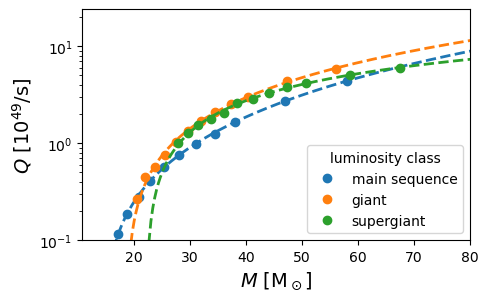

In [22]:
MS, GI, SG = 0, 1, 2 # luminosity classes
lc_label = ['main sequence', 'giant', 'supergiant']

fig, ax = plt.subplots(figsize=(5, 3))

# Draine ISM textbook table 15.1 data
mass = np.array([
    [15.6, 17.1, 18.8, 20.8, 22.9, 25.3, 28.0, 31.0, 34.4, 38.1, 46.9, 58.0],
    [20.6, 22.0, 23.7, 25.5, 27.5, 29.6, 32.0, 34.5, 37.4, 40.4, 47.4, 56.0],
    [27.8, 29.6, 31.5, 33.7, 36.0, 38.4, 41.2, 44.1, 47.3, 50.7, 58.5, 67.5]
])*const.M_sol
Q = 10**np.array([
    [47.88, 48.06, 48.27, 48.44, 48.61, 48.75, 48.88, 48.99, 49.10, 49.22, 49.44, 49.64],
    [48.42, 48.65, 48.75, 48.88, 49.01, 49.13, 49.23, 49.32, 49.40, 49.48, 49.64, 49.77],
    [49.00, 49.11, 49.19, 49.25, 49.31, 49.41, 49.46, 49.52, 49.58, 49.62, 49.70, 49.78]
])

exp = lambda x, a, b, c: a*x**b + c
mass_sm = np.linspace(15, 100, 256)*const.M_sol

popt_list = []
for idx_lc in [MS, GI, SG]:
    popt, _ = curve_fit(exp, mass[idx_lc]/const.M_sol, Q[idx_lc]/1e49)
    plt.plot(mass[idx_lc]/const.M_sol, Q[idx_lc]/1e49, lw=2, label=lc_label[idx_lc], color='C%d' % idx_lc, marker='o', linestyle='')
    plt.plot(mass_sm/const.M_sol, exp(mass_sm/const.M_sol, *popt), lw=2, linestyle='--', color='C%d' % idx_lc)
    popt_list.append(popt)

#plt.xscale('log')
plt.yscale('log')
plt.xlim(None, 80)
plt.xlabel(r'$M$ [${\rm M_\odot}$]', fontsize=14)
plt.ylabel(r'$Q$ [${\rm 10^{49}/s}$]', fontsize=14)
plt.ylim(1e-1)
plt.legend(title='luminosity class')

save_fig('QvsM')


In [180]:
m_Otype = 15.6 # minimum mass of Otype stars [Msol]
kroupa = IMF(mcut=[0.08, 0.5, 1.0], exp=[-0.3, -1.3, -2.3, -2.7]) # Kroupa IMF

Qsol = np.zeros(3)
imf_norm = kroupa.integrate()
for idx_lc in [MS, GI, SG]:
    imf_Q = popt_list[idx_lc][1]*kroupa.integrate(m_Otype, exp_add=popt_list[idx_lc][0]) + popt_list[idx_lc][2]*kroupa.integrate(m_Otype, exp_add=0)
    Qsol[idx_lc] = 1e49 * imf_Q / imf_norm

print('Qsol (V): %.3g 1/cm^2/s' % (Qsol[MS]))
print('Qsol (III): %.3g 1/cm^2/s' % (Qsol[GI]))
print('Qsol (I): %.3g 1/cm^2/s' % (Qsol[SG]))


Qsol (V): 2.84e+46 1/cm^2/s
Qsol (III): 6.65e+45 1/cm^2/s
Qsol (I): 1.09e+48 1/cm^2/s


In [181]:
Q = 1e49
m_Ostar = 15*const.M_sol
chi = 0.2

Qsol = Q*chi*const.M_sol/m_Ostar

print('Qsol: %.3g 1/cm^2/s' % (Qsol))


Qsol: 1.33e+47 1/cm^2/s


In [121]:
temp = 10000 # temperature inside Stromden sphere [K]
bturb = 1.0 # turbulence forcing parameter
mach = 10 # turbulent mach number
nH = 1e2 # H number density
dx = 10*const.pc # cell size
alphaB = 2.56e-13 * (temp/10000)**(-0.83) # case B recombination rate
QoverM = 5.85e+46

mstar = 4*np.pi/3 * alphaB*nH**2*dx**3/QoverM

mstar


5387.167434221639

In [993]:
temp = 100 # temperature inside Stromden sphere [K]
mach_turb = 10 # turbulent mach number
dx = 10*const.pc # cell size
alphaB = 2.56e-13 * (temp/10000)**(-0.83) # case B recombination rate
mstar = 3000*const.M_sol
nstar = 1

r_avg = dx/nstar/np.sqrt(6)
Qtot = Qsol*nstar/(4*np.pi*r_avg**2) * mstar/const.M_sol
nH_phot = np.sqrt(Qtot*mach_turb**2/(alphaB*dx))

nH_phot


112.5393694715985

In [179]:
Q = 1e49
m_Ostar = 15*const.M_sol
chi = 0.2

Qsol = Q*chi*const.M_sol/m_Ostar


1.3333333333333333e+47

Text(0.33, 0.75, 'limited by density')

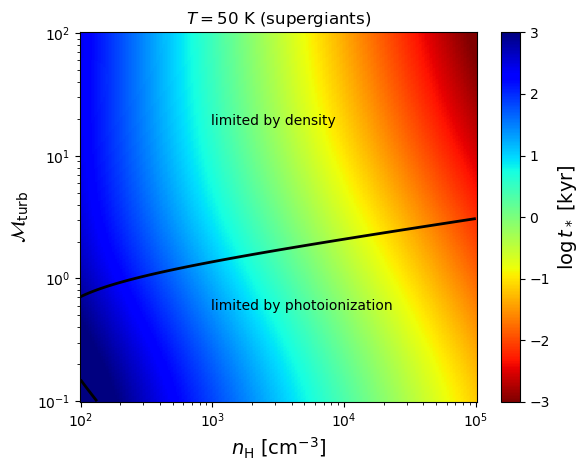

In [159]:
num = 256
idx_lc = SG

temp = 50
dx = 10*const.pc # cell size
mstar = 3000*const.M_sol # star particle mass
nstar = 10 # number of star particles
bturb = 10.0 # turbulence forcing parameter
dt = 500*const.yr

nH, mach_turb = np.meshgrid(np.logspace(2, 5, num), np.logspace(-1, 2, num))
rho = nH*const.m_H/const.X_cosmo
c_s = np.sqrt(const.k_B*temp/const.m_H) # sound speed
alpha_vir = 15/np.pi*c_s**2*(1+mach_turb**2)/(const.G*rho*dx**2) # virial parameter
alphaB = 2.56e-13 * (temp/10000)**(-0.83) # case B recombination rate

r_avg = dx/nstar/np.sqrt(6) # typical distance between stars
Qtot = Qsol[idx_lc]*nstar/(4*np.pi*r_avg**2) * mstar/const.M_sol
nH_phot = np.sqrt(Qtot*mach_turb**2/(alphaB*dx))
rho_phot = const.m_H*nH_phot/const.X_cosmo

s_crit_phot = np.log10(rho_phot/rho)
s_crit_grav = np.log(alpha_vir * (1 + 2 * mach_turb**4 / (1 + mach_turb**2))) # lognormal critical density for star formation
s_crit = np.maximum(s_crit_phot, s_crit_grav)
s_crit = s_crit_grav

sigma_s = np.sqrt(np.log(1 + bturb**2 * mach_turb**2)) # standard deviation of the lognormal subgrid density distribution
eps_sf = 1/2 * np.exp(3/8 * sigma_s**2) * (1 + erf((sigma_s**2 - s_crit) / np.sqrt(2 * sigma_s**2))) # star formation efficiency
tff = np.sqrt(3*np.pi/(32*const.G*rho))
lam = eps_sf*rho*dx**3*dt/(mstar*tff)
tstar = np.log(2)/lam*dt

im = plt.pcolormesh(nH, mach_turb, np.log10(tstar/const.kyr), cmap='jet_r', vmin=-3, vmax=3)
#im = plt.pcolormesh(nH, mach_turb, s_crit_grav-s_crit_phot, cmap='jet')
plt.contour(nH, mach_turb, s_crit_grav-s_crit_phot, levels=[0], colors='black', linewidths=2)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$n_{\rm H}$ [${\rm cm^{-3}}$]', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm turb}$', fontsize=14)
plt.colorbar(im).set_label(r'$\log t_*$ [kyr]', fontsize=14)
plt.title(r'$T = %.3g~{\rm K}$ (supergiants)' % temp)

plt.annotate('limited by photoionization', xy=(0.33, 0.25), xycoords='axes fraction')
plt.annotate('limited by density', xy=(0.33, 0.75), xycoords='axes fraction')

#save_fig('starform_sg')


Text(0.5, 1.0, '$\\mathcal{M}_{\\rm turb}=10$')

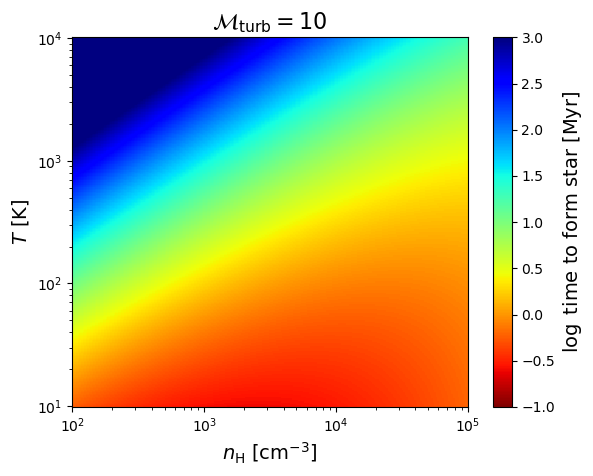

In [1053]:
num = 256
temp = 10000 # temperature inside Stromden sphere [K]
bturb = 1.0 # turbulence forcing parameter
mach_turb = 10
dx = 10*const.pc # cell size
dt = 500*const.yr
alphaB = 2.56e-13 * (temp/10000)**(-0.83) # case B recombination rate

nH, temp = np.meshgrid(np.logspace(2, 5, num), np.logspace(1, 4, num))
density = nH*const.m_H/const.X_cosmo
c_s = np.sqrt(const.k_B*temp/const.m_H) # sound speed
alpha_vir = 15/np.pi*c_s**2*(1+mach_turb**2)/(const.G*density*dx**2) # virial parameter
s_crit = np.log(alpha_vir * (1 + 2 * mach_turb**4 / (1 + mach_turb**2))) # lognormal critical density for star formation
sigma_s = np.sqrt(np.log(1 + bturb**2 * mach_turb**2)) # standard deviation of the lognormal subgrid density distribution
eps_sf = 1/2 * np.exp(3/8 * sigma_s**2) * (1 + erf((sigma_s**2 - s_crit) / np.sqrt(2 * sigma_s**2))) # star formation efficiency

mstar = 4*np.pi*alphaB*nH**2*dx**3/(3*Qsol)/(1+bturb**2*mach_turb**2)*const.M_sol
tff = np.sqrt(3*np.pi/(32*const.G*density))
lam = eps_sf*density*dx**3*dt/(mstar*tff)
tstar = np.log(2)/lam*dt

plt.pcolormesh(nH, temp, np.log10(tstar/const.Myr), cmap='jet_r', vmin=-1, vmax=3)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$n_{\rm H}$ [${\rm cm^{-3}}$]', fontsize=14)
plt.ylabel(r'$T$ [${\rm K}$]', fontsize=14)
plt.colorbar().set_label(r'$\log$ time to form star [Myr]', fontsize=14)
plt.title(r'$\mathcal{M}_{\rm turb}=10$', fontsize=16)

# save_fig('time_starform')


In [873]:
ntrail = 1000
nstar_list = np.array([2, 4, 8, 16, 32, 64, 128, 256, 512])
fac_list = np.zeros_like(nstar_list)

for i, nstar in enumerate(nstar_list):
    coords = np.random.random((3, nstar, ntrail))
    dis = np.sqrt(np.sum((coords[:, :, None, :] - coords[:, None, :, :])**2, axis=0))
    dis = np.ma.masked_array(dis, mask=dis==0.)
    fac_list[i] = np.mean(np.sum(1/dis**2, axis=(0, 1)))


Saved figure as 'nstartest-031420241543.png'


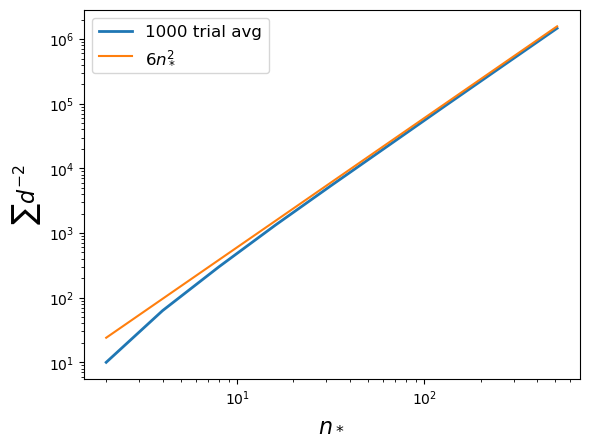

In [882]:
plt.plot(nstar_list, fac_list, lw=2, label='1000 trial avg')
plt.plot(nstar_list, 6*nstar_list**2, label=r'$6 n_*^2$')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$n_*$', fontsize=16)
plt.ylabel(r'$\sum d^{-2}$', fontsize=16)

plt.legend(fontsize=12)

save_fig('nstartest')

### photoionization front

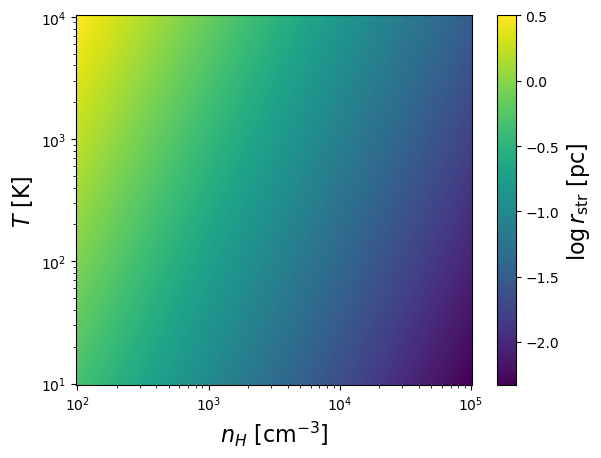

In [45]:
nH1d = np.logspace(2, 5, 128)
temp1d = np.logspace(1, 4, 128)
nH2d, temp2d = np.meshgrid(nH1d, temp1d)

Q0 = 1e49
alphaB = 2.56e-13 * (temp2d/10000)**(-0.83)
t_ion = 1/(alphaB*nH2d)
r_ion = (3*Q0/(4*np.pi*alphaB*nH2d**2))**(1/3)

plt.pcolormesh(nH2d, temp2d, np.log10(r_ion/const.pc))

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=16)
plt.ylabel(r'$T$ [${\rm K}$]', fontsize=16)
plt.colorbar().set_label(r'$\log r_{\rm str}$ [${\rm pc}$]', fontsize=16)

# save_fig('stromden')

#print('time: %.3g kyr' % (t_ion/const.kyr))
#print('radius: %.3g pc' % (r_ion/const.pc))


In [147]:
temp0 = 100
nH0 = 100
X = 0.75
dx = 10*const.pc
Q0 = 1e49
chi = 0.2
rho0 = nH0*const.m_H/X
eps_sf = 0.1

alphaB0 = 2.56e-13*(temp0/10000)**(-0.83)
mstar0 = 4*np.pi*alphaB0*nH0**2*dx**3/(3*chi*Q0)*const.M_sol
tdelay0 = np.sqrt(np.pi/6/const.G)*X**2/const.m_H**2*const.M_sol*alphaB0/chi/Q0*rho0**(1/2)/eps_sf

tdelay0/const.Myr


31.374864741499298

### closed box

In [3]:
aexp_list = np.linspace(1e-3, 0.1, 1000)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list, fill_value='extrapolate')


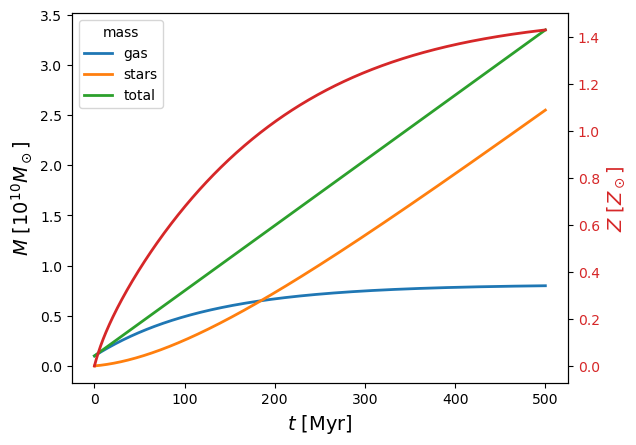

In [12]:
Z0 = 1e-3*const.Z_sol # initial metallicity
Zacc = 0.*const.Z_sol # accretion metallicity
Mgas0 = 1e9*const.M_sol # initial gas mass
Mdotacc = 65*const.M_sol/const.yr # gas accretion rate
tsf = 10*const.Myr # star formation timescale
eps = 0.1 # star formation efficiency
eta = 0.2 # mass fraction of OB stars
y = 0.1 # metallicity of typeII SNe ejecta

def dMdt(M, t):
    
    Mgas, Mmetal = M
    
    Mdotstar = eps*Mgas/tsf
    Mdotsn = eta*Mdotstar
    Mdotgas = Mdotacc - Mdotstar + Mdotsn
    Mdotmetal = Zacc*Mdotacc - (Mmetal/Mgas)*Mdotstar + y*Mdotsn
    
    return [Mdotgas, Mdotmetal]

t = np.linspace(0, 500*const.Myr, 512)
Mgas, Mmetal = odeint(dMdt, [Mgas0, Z0*Mgas0], t).T
Mtot = Mgas0+Mdotacc*t
Mstar = Mtot - Mgas

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(t/const.Myr, Mgas/(1e10*const.M_sol), lw=2, label='gas')
ax1.plot(t/const.Myr, Mstar/(1e10*const.M_sol), lw=2, label='stars')
ax1.plot(t/const.Myr, Mtot/(1e10*const.M_sol), lw=2, label='total')
ax2.plot(t/const.Myr, Mmetal/Mgas/const.Z_sol, lw=2, color='C3')
ax2.tick_params(axis='y', labelcolor='C3')

ax1.set_xlabel(r'$t$ [Myr]', fontsize=14)
ax1.set_ylabel(r'$M$ [$10^{10} M_\odot$]', fontsize=14)
ax2.set_ylabel(r'$Z$ [$Z_\odot$]', fontsize=14, color='C3')
ax1.legend(title='mass')

# save_fig('galaxy_toymodel')


### distribution

In [225]:
def poisson(k, lamb): return lamb**k * np.exp(-lamb) / factorial(k)

rho_init = 1e-21 # initial density
temp = 50 # temperature
mach_turb = 10 # turbulent Mach number
b_turb = 1.0 # turbulence forcing parameter
dx = 10*const.pc # resolution
dt = 500*const.yr # timestep
Ntrial = 2**13 # number of trials
rho_init_vec = np.full(Ntrial, rho_init)
t_iter = 1*const.Myr # iteration time
model = 2

mstar_list = np.array([120, 600, 3000, 15000])*const.M_sol

c_s = np.sqrt(const.k_B * temp / const.m_p) # sound speed
N_iter = round(t_iter/dt)
Mstar_avg = np.zeros((4, N_iter))
Mstar_std = np.zeros((4, N_iter))

print('Average stellar mass')
for j, mstar in enumerate(mstar_list):

    rho = np.full(Ntrial, rho_init)
    nstar = np.zeros(Ntrial, dtype=int)
    #if model == 2: rho_start = np.full(Ntrial, rho_init)
    #if model == 2: count = np.zeros(Ntrial, dtype=int)
    
    for i in range(N_iter):

        tff = np.sqrt(3*np.pi/(32*const.G*rho))
        #alpha_vir = 15 / np.pi * c_s**2 * (1 + mach_turb**2) / (const.G * rho * dx**2) # virial parameter
        #eps_sf = calc_eps_sf(alpha_vir, mach_turb, b_turb=b_turb)
        eps_sf = np.full(Ntrial, 0.13)
        eps_sf[rho < 4e-21] = 0
        lamb = eps_sf*rho*dx**3*dt/tff/mstar # compute Poisson parameter
        nstar1trial = np.random.poisson(lam=lamb, size=Ntrial) # sample Poisson distribution
        cond = nstar1trial*mstar > 0.9*rho*dx**3
        nstar1trial = np.minimum(nstar1trial, np.floor(0.9*rho*dx**3/mstar).astype(int))
        if model == 0:
            pass
        elif model == 1:
            rho = rho - nstar1trial*mstar/dx**3 # depletion
        elif model == 2:
            #count[nstar1trial>0] = 0
            #rho_start[nstar1trial>0] = rho[nstar1trial>0]
            rho = rho - nstar1trial*mstar/dx**3 # depletion
            rho += 99/N_iter*rho_init
            #rho *= (1 - ((i)*dt/tff)**2)**2 / (1 - ((i+1)*dt/tff)**2)**2
            #rho = rho_start / (1 - (count*dt/tff)**2)**2
            #count += 1
        nstar += nstar1trial # add contribution to nstar
        Mstar_avg[j, i] = np.mean(nstar)*mstar/const.M_sol 
        Mstar_std[j, i] = np.std(nstar)*mstar/const.M_sol
    print('mstar=%d Msol: %.3g +/- %d Msol' % (mstar/const.M_sol, Mstar_avg[j, -1], Mstar_std[j, -1]))


Average stellar mass
mstar=120 Msol: 2.98e+05 +/- 4865 Msol
mstar=600 Msol: 2.97e+05 +/- 10922 Msol
mstar=2999 Msol: 2.98e+05 +/- 24410 Msol
mstar=15000 Msol: 2.97e+05 +/- 54449 Msol


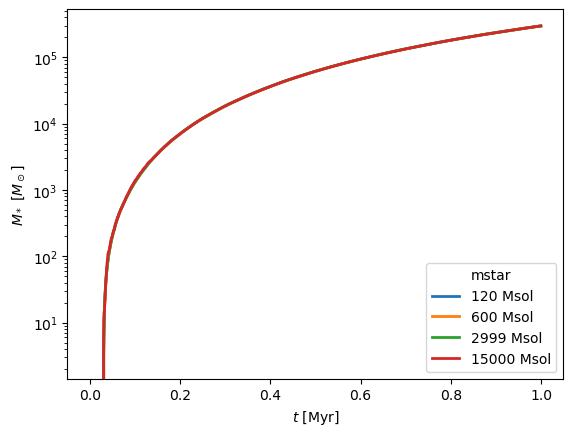

In [226]:
t = np.arange(N_iter)*dt

for j, mstar in enumerate(mstar_list):

    plt.plot(t/const.Myr, Mstar_avg[j], label='%d Msol' % (mstar/const.M_sol), lw=2)
    #plt.fill_between(t/const.Myr, Mstar_avg[j] - Mstar_std[j], Mstar_avg[j] + Mstar_std[j], alpha=0.1)
    
plt.legend(title='mstar')

plt.xlabel(r'$t$ [Myr]')
plt.ylabel(r'$M_*$ [$M_\odot$]')

plt.yscale('log')


In [59]:
rho = 1e-21 # initial density
temp = 50 # temperature
mach_turb = 10 # turbulent Mach number
b_turb = 1.0 # turbulence forcing parameter
dx = 10*const.pc # resolution
dt = 500*const.yr # timestep
Ntrial = 2**14 # number of trials
t_iter = 1*const.Myr # iteration time
model = 1

tff = np.sqrt(3*np.pi/(32*const.G*rho))
alpha_vir = 15 / np.pi * c_s**2 * (1 + mach_turb**2) / (const.G * rho * dx**2) # virial parameter
eps_sf = calc_eps_sf(alpha_vir, mach_turb, b_turb=b_turb)


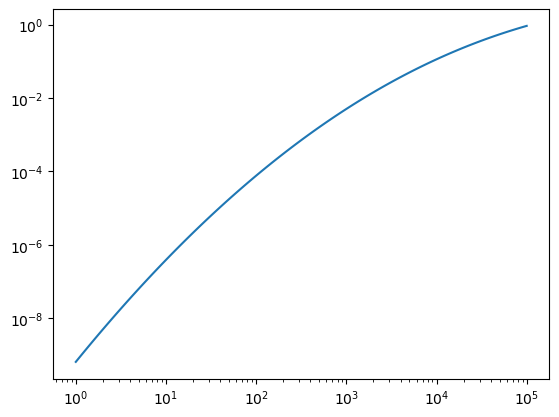

In [140]:
temp = 50 # temperature
mach_turb = 10 # turbulent Mach number
b_turb = 1.0 # turbulence forcing parameter
dx = 10*const.pc # resolution
num = 100

mstar_list = np.logspace(0, 5, num)*const.M_sol

eps_sf = np.zeros(num)
for i, mstar in enumerate(mstar_list):
    rho = mstar/(0.9*dx**3)
    alpha_vir = 15 / np.pi * c_s**2 * (1 + mach_turb**2) / (const.G * rho * dx**2) # virial parameter
    eps_sf[i] = calc_eps_sf(alpha_vir, mach_turb, b_turb=b_turb)

plt.loglog(mstar_list/const.M_sol, eps_sf)
    

16.826178828459597


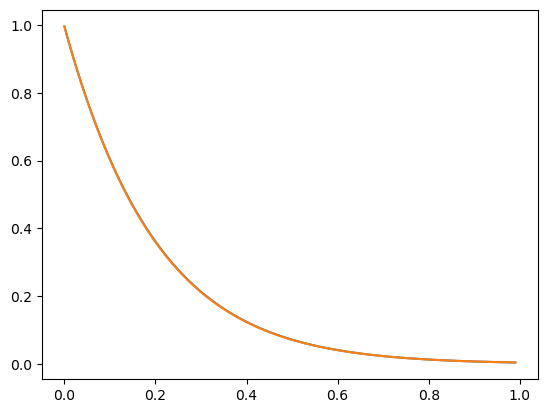

In [801]:
def binom(k, n, p): return comb(n, k) * p**k * (1-p)**(n-k)
def poisson(k, lamb): return lamb**k * np.exp(-lamb) / factorial(k)

rho = 1e-21 # density
temp = 100 # temperature
mach_turb = 10 # turbulent Mach number
b_turb = 1.0 # turbulence forcing parameter
dx = 10*const.pc # resolution
mstar = 600*const.M_sol
dt = 500*const.yr
tff = np.sqrt(3*np.pi/(32*const.G*rho))

c_s = np.sqrt(const.k_B * temp / const.m_p) # sound speed
alpha_vir = 15 / np.pi * c_s**2 * (1 + mach_turb**2) / (const.G * rhobar * dx**2) # virial parameter
eps_sf = calc_eps_sf(alpha_vir, mach_turb, b_turb=b_turb)

nstar = np.arange(0, 1, 0.01)
print(eps_sf*rho*dx**3/mstar)
pdf = binom(nstar, eps_sf*rho*dx**3/mstar, dt/tff)
pdf2 = poisson(nstar, eps_sf*rho*dx**3/mstar*dt/tff)
plt.plot(nstar, pdf)
plt.plot(nstar, pdf2)


In [802]:
def calc_sprime(s, tau, sigma_s): 
    return np.log((1+2*tau*np.exp(s)-np.sqrt(1+4*tau*np.exp(s)))/(2*tau**2*np.exp(s)))

def calc_pdf(s, sigma_s):
    return np.exp(-s**2/(2*sigma_s**2))/np.sqrt(2*np.pi*sigma_s)

def calc_pdfprime(s, tau, sigma_s): 
    sprime = calc_sprime(s, tau, sigma_s)
    q = (1-tau*np.exp(sprime))**3/(1+tau*np.exp(sprime))
    return q*calc_pdf(sprime, sigma_s)

def mdot(rhobar, s_crit, tau, sigma_s):
    sprime_crit = calc_sprime(s_crit, tau, sigma_s)
    tff = np.sqrt(3*np.pi/(32*const.G*rhobar))
    dmdrho = sprime_crit/s_crit * calc_pdfprime(s_crit, tau, sigma_s)
    drhodt = 6*rhobar/tff/(1-tau**2)**3
    return dmdrho*drhodt


Text(0, 0.5, 'PDF')

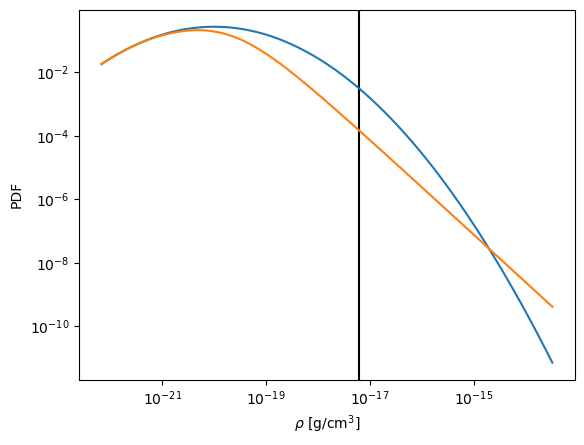

In [766]:
rhobar = 1e-20 # density
temp = 50 # temperature
mach_turb = 10 # turbulent Mach number
b_turb = 1.0 # turbulence forcing parameter
dx = 10*const.pc # resolution
mstar = 3000*const.M_sol
tau = 0.1

c_s = np.sqrt(const.k_B * temp / const.m_p) # sound speed
alpha_vir = 15 / np.pi * c_s**2 * (1 + mach_turb**2) / (const.G * rhobar * dx**2) # virial parameter
s_crit = np.log(alpha_vir * (1 + 2 * mach_turb**4 / (1 + mach_turb**2))) # lognormal critical density for star formation
sigma_s = np.sqrt(np.log(1 + b_turb**2 * mach_turb**2)) # std of subgrid density distribution
pdf = calc_pdf(s, sigma_s)

s = np.linspace(-5, 15, 256)
rho = rhobar * np.exp(s)
rho_crit = rhobar * np.exp(s_crit)
pdfprime = calc_pdfprime(s, tau, sigma_s)

plt.axvline(x=rho_crit, color='black')
#plt.axhline(y=1/mach_turb**6, color='black')

plt.plot(rho, pdf)
plt.plot(rho, pdfprime)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel('PDF')

#mdot(rhobar, s_crit, tau, sigma_s)


### feedback free

Saved figure as 'eps_sf_crit-030120241059.png'


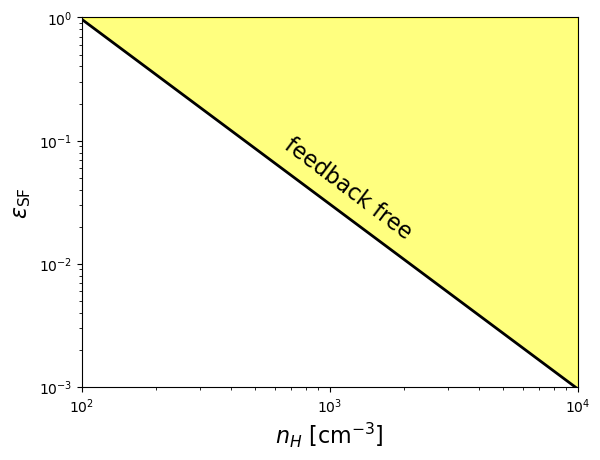

In [70]:
dx = 10*const.pc
mstar = 3000*const.M_sol
t_fbk = 3*const.Myr

nH = np.logspace(2, 4, 512)
rho = nH*const.m_H/const.X_cosmo
tstar = np.log(2)*np.sqrt(3*np.pi/(32*const.G)) * mstar/(1.*rho**(3/2)*dx**3)
eps_sf = np.log(2)*np.sqrt(3*np.pi/(32*const.G)) * mstar/(t_fbk*rho**(3/2)*dx**3)

plt.plot(nH, eps_sf, lw=2, color='black')
plt.fill_between(nH, eps_sf, np.ones_like(eps_sf), color='yellow', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2, 1e4)
plt.ylim(1e-3, 1)

plt.xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=16)
plt.ylabel(r'$\varepsilon_{\rm SF}$', fontsize=16)
plt.annotate('feedback free', xy=(0.4, 0.4), fontsize=16, rotation=(-37), xycoords='axes fraction')

save_fig('eps_sf_crit')


Saved figure as 'ffb_starmass-030120241122.png'


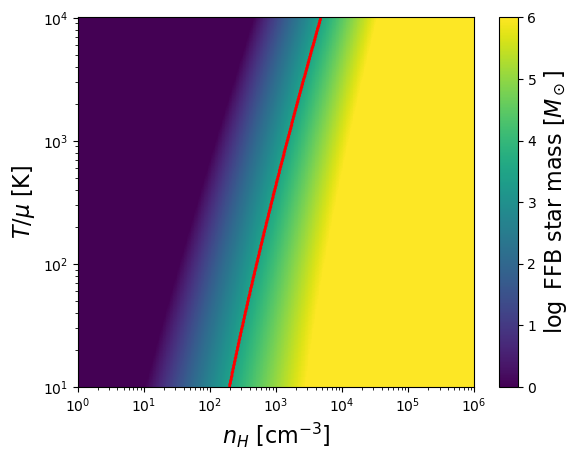

In [122]:
dx = 10*const.pc
mstar = 3000*const.M_sol
t_fbk = 3*const.Myr
b_turb = 1.0
mach_turb = 10
nbin = 512

nH = np.logspace(0, 6, 512, nbin)
temp = np.logspace(1, 4, nbin)
nH, temp = np.meshgrid(nH, temp, indexing='ij')
rho = nH*const.m_H/const.X_cosmo
energy_turb = 3/2 * const.k_B * temp * mach_turb**2 / const.m_p
eps_sf = calc_eps_sf2(rho, energy_turb, temp, dx, b_turb)
Mstar = 1/np.log(2)*np.sqrt(32*const.G/(3*np.pi)) * eps_sf * rho**(3/2) * dx**3 * t_fbk

plt.pcolormesh(nH, temp, np.log10(Mstar/const.M_sol), vmin=0, vmax=6, cmap='viridis')
plt.xscale('log')
plt.yscale('log')
cbar = plt.colorbar()
cbar.set_label(r'$\log$ FFB star mass [$M_\odot$]', fontsize=16)
plt.xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=16)
plt.ylabel(r'$T/\mu$ [${\rm K}$]', fontsize=16)
cond_ffb = eps_sf > np.log(2)*np.sqrt(3*np.pi/(32*const.G)) * mstar/(t_fbk*rho**(3/2)*dx**3)
plt.contour(nH, temp, cond_ffb, levels=[0, 1], colors='red', linewidths=2)

# save_fig('ffb_starmass')


### feedback model

In [152]:
dx = 10 * const.pc
n_H = 100
metallicity = const.Z_sol

def fbk_ramses(n_H, metallicity, dx):

    r_cool = 3 * const.pc * (metallicity / const.Z_sol)**(-0.082) * (n_H / 100)**(-0.42)
    mom_SN = 1.42e5 * const.km * const.M_sol * (metallicity / const.Z_sol)**(-0.137) * (n_H / 100)**(-0.16)
    mom = mom_SN * np.minimum(1, (dx / r_cool)**(3/2)) * (r_cool < 4 * dx)
    return mom

def fbk_martizzi(n_H, metallicity, dx):
    
    alpha = -11 * (metallicity / const.Z_sol)**(0.07) * (n_H / 100)**(0.114)
    r_cool = 6.3 * const.pc * (metallicity / const.Z_sol)**(-0.05) * (n_H / 100)**(-0.42)
    r_thm = 9.2 * const.pc * (metallicity / const.Z_sol)**(-0.067) * (n_H / 100)**(-0.44)
    r0 = 2.4 * const.pc * (metallicity / const.Z_sol)**(0.021) * (n_H / 100)**(-0.35)
    r_mom = 8 * const.pc * (metallicity / const.Z_sol)**(-0.058) * (n_H / 100)**(-0.46)
    
    energy_SN = 1e51
    mom_SN = 1.42e5 * const.km * const.M_sol
    
    energy = energy_SN * ((r_cool - dx) + (dx / r_cool)**alpha * (dx > r_cool) * (r_thm > dx) + (r_thm / r_cool)**alpha * (r > r_thm))
    mom = mom_SN * ((dx / r0)**1.5 * (r_mom > dx) + (r_mom / r0) * (dx > r_mom))
    
    return energy, mom

fbk_ramses(1e-18, const.Z_sol, 10*const.pc)


0.0

### massive star mass fraction

In [4]:
def kroupa(m):
    imf = np.zeros_like(m)
    imf[m < 0.08] = 25 * m[m < 0.08]**(-0.3)
    imf[(m > 0.08) * (m < 0.5)] = 2 * m[(m > 0.08) * (m < 0.5)]**(-1.3)
    imf[(m > 0.5) * (m < 1.0)] = m[(m > 0.5) * (m < 1.0)]**(-2.3)
    imf[m > 1.0] = m[m > 1.0]**(-3.7)
    return imf

m = np.logspace(-2, 1)
imf = kroupa(m)


In [213]:
m_SNe = 8 # mass above which Type II SNe occur

kroupa_norm = 25 / (-0.3 + 2) * 0.08**(-0.3 + 2) \
    + 2 / (-1.3 + 2) * (0.5**(-1.3 + 2) - 0.08**(-1.3 + 2)) \
    + 1 / (-2.3 + 2) * (1.0**(-2.3 + 2) - 0.5**(-2.3 + 2)) \
    + -1 / (-2.7 + 2) * 1.0**(-2.7 + 2) # integral of the Kroupa IMF
kroupa_SNe = -1 / (-2.7 + 2) * m_SNe**(-2.7 + 2) # integral of the Kroupa IMF above m_SNe
eps_SNe = kroupa_SNe / kroupa_norm # mass fraction of stars that go SNe

eps_SNe


0.0907728971746926

In [215]:
m_SNe = 15 # mass above which Type II SNe occur

kroupa_norm = 25 / (-0.3 + 2) * 0.08**(-0.3 + 2) \
    + 2 / (-1.3 + 2) * (0.5**(-1.3 + 2) - 0.08**(-1.3 + 2)) \
    + 1 / (-2.3 + 2) * (1.0**(-2.3 + 2) - 0.5**(-2.3 + 2)) \
    + -1 / (-2.7 + 2) * 1.0**(-2.7 + 2) # integral of the Kroupa IMF
kroupa_SNe = -1 / (-2.7 + 1) * m_SNe**(-2.7 + 1) # integral of the Kroupa IMF above m_SNe
eps_SNe = kroupa_SNe / kroupa_norm # number fraction of stars that go SNe

eps_SNe


0.0016047713639806664

### multi-freefall

/tmp/ipykernel_3197528/284124865.py:12: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(alpha_vir, mach_turb, np.log10(epsilon_SF), levels=[-3, -2, -1, 0, 1])


Text(0, 0.5, '$\\mathcal{M}_{\\rm turb}$')

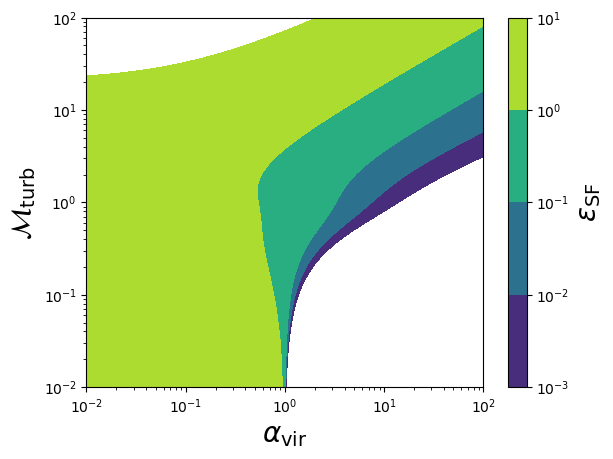

In [6]:
alpha_vir_extrema = (1e-2, 1e2)
mach_turb_extrema = (1e-2, 1e2)
num = 300
b_turb = 1.0

alpha_vir_1d = np.logspace(*np.log10(alpha_vir_extrema), num)
mach_turb_1d = np.logspace(*np.log10(mach_turb_extrema), num)
alpha_vir, mach_turb = np.meshgrid(alpha_vir_1d, mach_turb_1d, indexing='ij')
epsilon_SF = calc_eps_sf(alpha_vir, mach_turb, b_turb=b_turb)
rho_norm = (1 + mach_turb**2) / alpha_vir

im = plt.contourf(alpha_vir, mach_turb, np.log10(epsilon_SF), levels=[-3, -2, -1, 0, 1])

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$\alpha_{\rm vir}$", fontsize=20)
plt.ylabel(r"$\mathcal{M}_{\rm turb}$", fontsize=20)

# save_fig("SFE-alpha-mach")


/tmp/ipykernel_397939/2042395721.py:15: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])


Text(0.5, 1.0, '$b_{\\rm turb} = 1$')

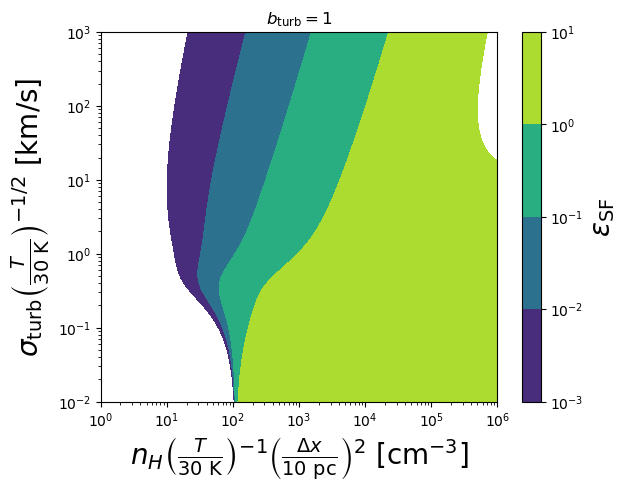

In [51]:
num = 1000
temp = 30
dx = 10 * const.pc
b_turb = 1.0

n_H_extrema = (1e0, 1e6)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')
rho = n_H * const.m_p
eps_sf = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)

im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$b_{\rm turb} = %.2g$' % b_turb)

#save_fig("bturb0p3")



In [ ]:
num = 1000
temp = 30
dx = 10 * const.pc
b_turb = 1.0

n_H_extrema = (1e0, 1e6)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')
rho = n_H * const.m_p
eps_sf = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)

im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$b_{\rm turb} = %.2g$' % b_turb)

#save_fig("bturb0p3")



/tmp/ipykernel_397939/1875624377.py:19: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])
/tmp/ipykernel_397939/1875624377.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], alpha=0.2)


Text(0.5, 1.0, '$m_* = 3000 M_\\odot$')

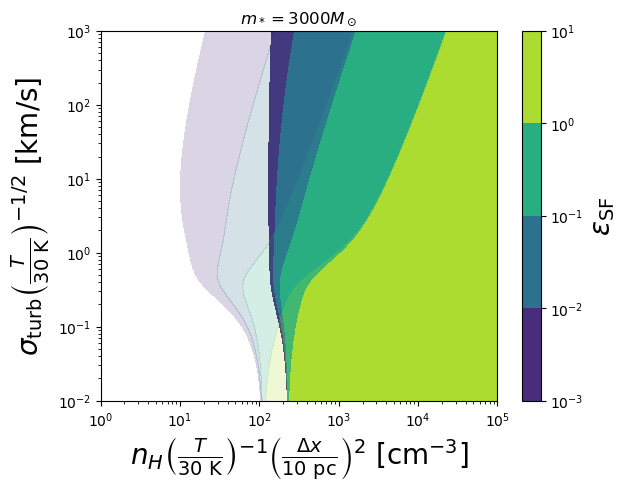

In [70]:
num = 1000
temp = 30
dx = 10 * const.pc
b_turb = 1.0
m_star = 3000 * const.M_sol

n_H_extrema = (1e0, 1e5)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')
rho = n_H * const.m_p
epsilon_SF = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)

eps_sf_fiducial = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)
eps_sf = calc_eps_sf2(rho - m_star/dx**3, 3/2*vel_turb**2, temp, dx=dx, b_turb=b_turb)

im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])
plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], alpha=0.2)

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$m_* = %d M_\odot$' % (m_star / const.M_sol))

#save_fig("epssf_mstar15000")



/tmp/ipykernel_397939/3034852600.py:23: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])
/tmp/ipykernel_397939/3034852600.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], alpha=0.2)


Text(0.5, 1.0, '$m_* = 3000 M_\\odot$ vs $m_* = 15000 M_\\odot$')

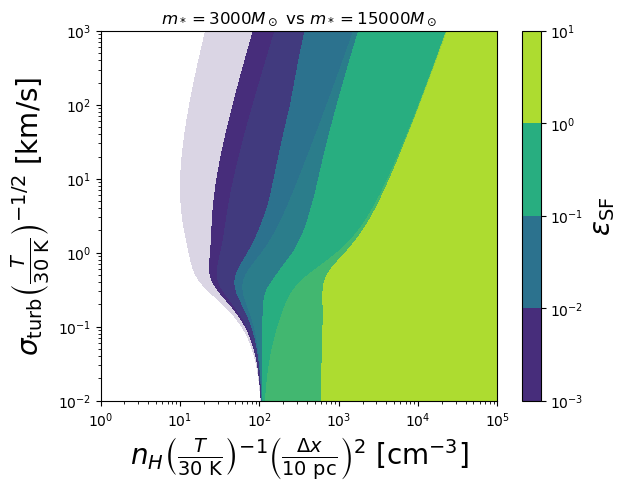

In [102]:
num = 1000
temp = 30
dx = 10 * const.pc
b_turb = 1.0
m_star = 3000 * const.M_sol
m_star_fiducial = 15000 * const.M_sol

n_H_extrema = (1e0, 1e5)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')
rho = n_H * const.m_p
epsilon_SF = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)

eps_sf_fiducial = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx=dx, b_turb=b_turb)
eps_sf = np.zeros_like(eps_sf_fiducial)
for i in range(0, int(m_star_fiducial/m_star)):
    eps_sf += np.nan_to_num(calc_eps_sf2(rho - i*m_star/dx**3, 3/2*vel_turb**2, temp, dx=dx, b_turb=b_turb))
eps_sf /= int(m_star_fiducial/m_star)

im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])
plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], alpha=0.2)

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$m_* = %d M_\odot$ vs $m_* = %d M_\odot$' % (m_star / const.M_sol, m_star_fiducial / const.M_sol))

#save_fig("epssf_mstar_comp2")



/tmp/ipykernel_397939/1958851675.py:1: RuntimeWarning: invalid value encountered in divide
  im = plt.contourf(n_H, vel_turb / const.km, eps_sf / eps_sf_fiducial, levels=np.linspace(0, 1, 200), cmap='jet')
/tmp/ipykernel_397939/1958851675.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.contour(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], colors='black', linestyles='-')


Saved figure as 'epssf_ratio_comp2-021220241305.png'


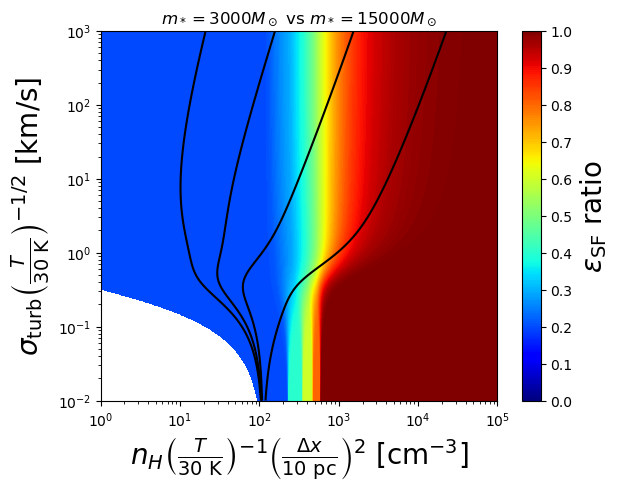

In [103]:
im = plt.contourf(n_H, vel_turb / const.km, eps_sf / eps_sf_fiducial, levels=np.linspace(0, 1, 200), cmap='jet')
plt.contour(n_H, vel_turb / const.km, np.log10(eps_sf_fiducial), levels=[-3, -2, -1, 0, 1], colors='black', linestyles='-')

plt.xscale('log')
plt.yscale('log')
plt.colorbar(im, ticks=np.arange(0, 1.1, 0.1)).set_label(r"$\varepsilon_{\rm SF}$ ratio", fontsize=20)

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$m_* = %d M_\odot$ vs $m_* = %d M_\odot$' % (m_star / const.M_sol, m_star_fiducial / const.M_sol))

save_fig("epssf_ratio_comp2")


In [217]:
temp = 30
dx = 10*const.pc
b_turb = 1.0
mach = 500
c_s = np.sqrt(const.k_B * temp / const.m_p)
rho = 1e-20

sigma_s = np.sqrt(np.log(1 + b_turb**2 * mach**2))
c_s = np.sqrt(const.k_B * temp / const.m_p)
alpha_vir = 15 / np.pi * 2 * c_s**2 * (1 + mach**2) / (const.G * rho * dx**2)
s_min = np.log(alpha_vir * 2 * mach**4 / (1 + mach**2))
s_max = np.sqrt(2 * sigma_s**2) * erfinv(1 - 2 / mach**6) + sigma_s**2

s_min, s_max

(22.260481751871627, 41.664021430801064)

/tmp/ipykernel_397939/3815413032.py:24: RuntimeWarning: divide by zero encountered in log10
  im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])


Text(0.5, 1.0, '$b_{\\rm turb} = 1$')

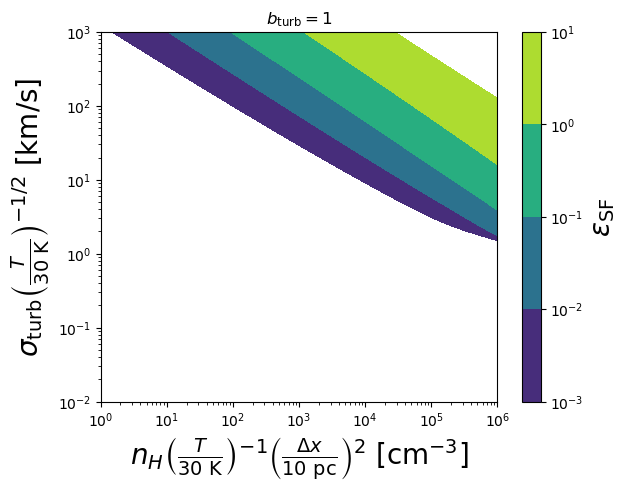

In [218]:
num = 1000
temp = 30
dx = 10*const.pc
b_turb = 1.0

n_H_extrema = (1e0, 1e6)
vel_turb_extrema = (1e-2 * const.km, 1e3 * const.km)

n_H_1d = np.logspace(*np.log10(n_H_extrema), num)
vel_turb_1d = np.logspace(*np.log10(vel_turb_extrema), num)
n_H, vel_turb = np.meshgrid(n_H_1d, vel_turb_1d, indexing='ij')

rho = n_H*const.m_p
energy_turb = 3/2*vel_turb**2
alpha_vir = 15 / np.pi * 2 * c_s**2 * (1 + mach**2) / (const.G * rho * dx**2)
c_s = np.sqrt(const.k_B * temp / const.m_p)
mach = vel_turb / c_s
sigma_s = np.sqrt(np.log(1 + b_turb**2 * mach**2))
s_min = np.log(alpha_vir * 2 * mach**4 / (1 + mach**2))
s_max = np.sqrt(2 * sigma_s**2) * erfinv(1 - 2 / mach**6) + sigma_s**2
eps_sf = np.exp(3/8*sigma_s**2) * (erf((sigma_s**2 - s_min) / (np.sqrt(2*sigma_s**2))) - erf((sigma_s**2 - s_max) / (np.sqrt(2*sigma_s**2))))
eps_sf[eps_sf < 0] = 0.

im = plt.contourf(n_H, vel_turb / const.km, np.log10(eps_sf), levels=[-3, -2, -1, 0, 1])

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(im)
cbar.set_label(r"$\varepsilon_{\rm SF}$", fontsize=20)
cbar.set_ticks([-3, -2, -1, 0, 1], labels=[r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"])

plt.xlabel(r"$n_H \left( \frac{T}{%d~{\rm K}} \right)^{-1} \left( \frac{\Delta x}{%d~{\rm pc}} \right)^2$ [${\rm cm^{-3}}$]" % (temp, dx / const.pc), fontsize=20)
plt.ylabel(r"$\sigma_{\rm turb} \left( \frac{T}{%d~{\rm K}} \right)^{-1/2}$ [${\rm km/s}$]" % temp, fontsize=20)

plt.title(r'$b_{\rm turb} = %.2g$' % b_turb)

#save_fig("eps_sf_attempt")


### timescales

Saved figure as 'dekel1-022820241651.png'


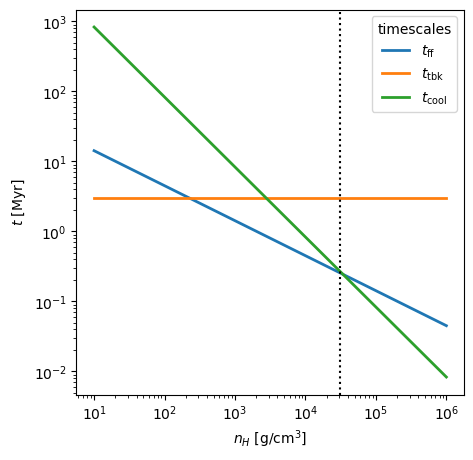

In [18]:
num = 100
metallicity = 1/3 * const.Z_sol
temp = 10**4
C = 1

M_cl = 10**6 * const.M_sol
V_w = 10**3.5 * const.km
R_gal = 1 * const.kpc
M_gen = 10**9 * const.M_sol
t_fbk0 = 3 * const.Myr

n_H_min, n_H_max = 10, 10**(6)
n_H = np.logspace(np.log10(n_H_min), np.log10(n_H_max), num) # Hydrogen number density
rho = n_H * const.m_H / const.X_cosmo
t_ff = np.sqrt(3 * np.pi / (32 * const.G * rho))
t_fbk = np.full_like(rho, t_fbk0)
t_cool = 0.87 * const.Myr * (n_H / 10**3.5)**(-1) * (metallicity / const.Z_sol)**(-1) * (temp / 10**4) * np.exp(0.009 * (temp / 10**4)**(-1)) * C**(-1)
# t_sh = 5 * const.Myr * (n_H / 10**3.5)**(-1/6) * (M_cl / (10**6 * const.M_sol))**(1/3) * (V_w / (10**3.5 * const.km))**(-1/2) * (R_gal / const.kpc) * (M_gen / (10**9 * const.M_sol))**(-1/2)
n_cool = 3.4e3 * (metallicity / const.Z_sol)**(-2) * (temp / 10**4)**2 * C**(-2)
n_ffb = const.X_cosmo * 3*np.pi/(32*const.G*t_fbk0**2) / const.m_H

plt.figure(figsize=(5, 5))

plt.plot(n_H, t_ff / const.Myr, lw=2, label=r'$t_{\rm ff}$')
plt.plot(n_H, t_fbk / const.Myr, lw=2, label=r'$t_{\rm tbk}$')
plt.plot(n_H, t_cool / const.Myr, lw=2, label=r'$t_{\rm cool}$')
# plt.plot(n_H, t_sh / const.Myr, lw=2, label=r'$t_{\rm shield}$')
plt.axvline(x=n_cool, color='black', linestyle=':')
#plt.axvspan(n_ffb, n_H_max, color='yellow', alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_H$ [${\rm g/cm^3}$]')
plt.ylabel(r'$t$ [${\rm Myr}$]')
plt.legend(title='timescales')

save_fig('dekel1')


Saved figure as 'mstartemp-013120241236.png'


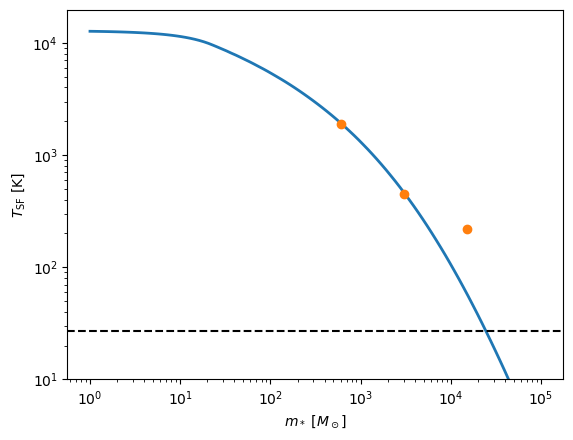

In [90]:
m_star = np.logspace(0, 5, 100) * const.M_sol
time_starform = 0.1*const.Myr
dt = 500*const.yr
rho_starform = 1e-20
energy_turb_starform = 1e13
dx = 10*const.pc

num_tstep = time_starform / dt
m_gas = -m_star * np.log(1 - 0.5) / num_tstep
t_ff_starform = np.sqrt(3 * np.pi / (32 * const.G * rho_starform))
eps_sf = m_gas / dx**3 / dt / rho_starform * t_ff_starform

temp = np.logspace(1, 4, 100)
eps_sf_interp = interp1d(calc_eps_sf2(rho_starform, energy_turb_starform, temp, dx), temp, fill_value='extrapolate')

plt.plot(m_star / const.M_sol, eps_sf_interp(eps_sf), lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m_*$ [$M_\odot$]')
plt.ylabel(r'$T_{\rm SF}$ [${\rm K}$]')
plt.axhline(y=27, color='black', linestyle='--')

plt.plot([600, 3000, 15000], [1890, 446, 218], 'o')
plt.ylim(10)

save_fig('mstartemp')
